In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import itertools

In [16]:
import ipynb

In [11]:
from functions import prep_split

In [26]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [28]:
from statsmodels.tsa.stattools import adfuller

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('/Users/Daniyar/Mountains/Data/df_final_timeseries.csv', index_col="time")

In [5]:
df.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'temp_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'clouds_all_Barcelona',
       'weather_broken clouds_Barcelona', 'weather_few clouds_Barcelona',
       'weather_light rain_Barcelona', 'weather_others_Barcelona',
       'weather_scattered clouds_Barcelona', 'weather_sky is clear_Ba

In [6]:
df_important = df[['price day ahead','hour','forecast solar day ahead','generation solar',
                   'generation other renewable', 'temp_Madrid','temp_Seville','price actual']]


In [14]:
df_important.head()

,price day ahead,hour,forecast solar day ahead,generation solar,generation other renewable,temp_Madrid,temp_Seville,price actual,label_shifted
time,,,,,,,,,
2014-12-31 23:00:00+00:00,50.10,23.0,17.0,49.0,73.0,267.325,273.375,65.41,59.32
2015-01-01 00:00:00+00:00,48.10,0.0,16.0,50.0,71.0,267.325,273.375,64.92,56.04
2015-01-01 01:00:00+00:00,47.33,1.0,8.0,50.0,73.0,266.186,274.086,64.48,53.63
2015-01-01 02:00:00+00:00,42.27,2.0,2.0,50.0,75.0,266.186,274.086,59.32,51.73
2015-01-01 03:00:00+00:00,38.41,3.0,9.0,42.0,74.0,266.186,274.086,56.04,51.43


In [7]:
X = df_important.drop(columns = ['price actual'])
y_price = df_important['price actual']

In [12]:
X_train, X_test, y_train, y_test = prep_split(df_important, 
                                               columns_drop=[], 
                                               label='price actual', 
                                               train_end_date='2017-12-31 23:00:00+00:00',
                                               hours_ahead=3)

In [19]:
def sarimax_model_selection(y_train, X_train, y_test, X_test, p, d, q, P, D, Q, s):
    """
    Fits a SARIMAX model with the given parameters and returns the RMSE on the test set.

    Parameters:
    - y_train: training target series.
    - X_train: training exogenous variables (if any).
    - y_test: testing target series.
    - X_test: testing exogenous variables (if any).
    - p: AR order for non-seasonal model.
    - d: Differencing order for non-seasonal model.
    - q: MA order for non-seasonal model.
    - P: AR order for seasonal model.
    - D: Differencing order for seasonal model.
    - Q: MA order for seasonal model.
    - s: Number of observations per season (seasonal periodicity).

    Returns:
    - rmse: Root Mean Square Error of the model's forecast on the test set.
    """
    model = sm.tsa.statespace.SARIMAX(y_train,
                                      exog=X_train,
                                      order=(p, d, q),
                                      seasonal_order=(P, D, Q, s),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    results = model.fit(disp=False)

    forecast = results.get_forecast(steps=len(y_test), exog=X_test)
    mean_forecast = forecast.predicted_mean

    rmse = mean_squared_error(y_test, mean_forecast, squared=False)
    return rmse, results, forecast, mean_forecast

In [20]:
rmse, results, forecast, mean_forecast = sarimax_model_selection(y_train, X_train, 
                                                                 y_test, X_test, 1, 0, 2, 1, 0, 2, 12)

In [21]:
rmse

6.33140638057536

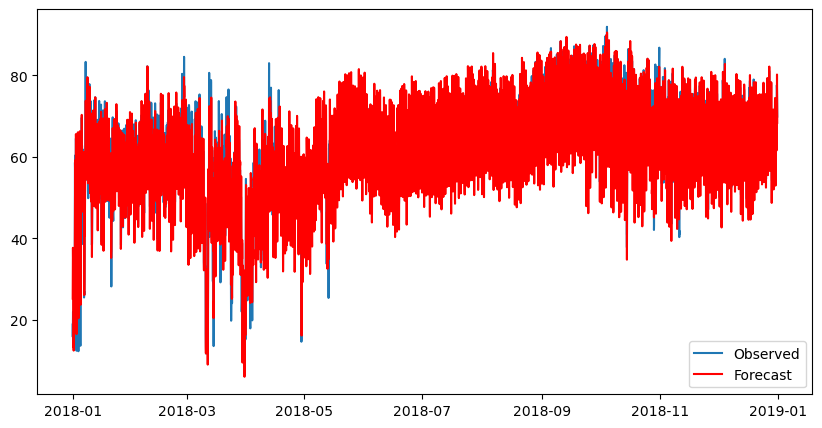

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Observed')
plt.plot(y_test.index, mean_forecast, label='Forecast', color='r')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

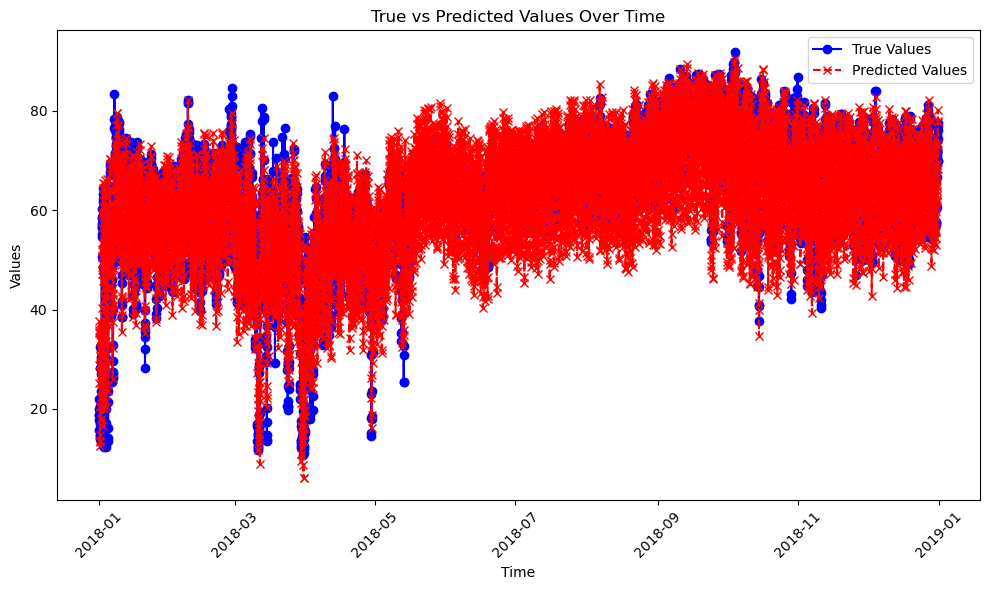

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, y_test, marker='o', color='blue', label='True Values') 
plt.plot(X_test.index, mean_forecast, marker='x', color='red', linestyle='--', label='Predicted Values')
plt.title('True vs Predicted Values Over Time')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45) # Rotate x-axis labels for better readability plt. grid(True)
plt.tight_layout ()
plt.show

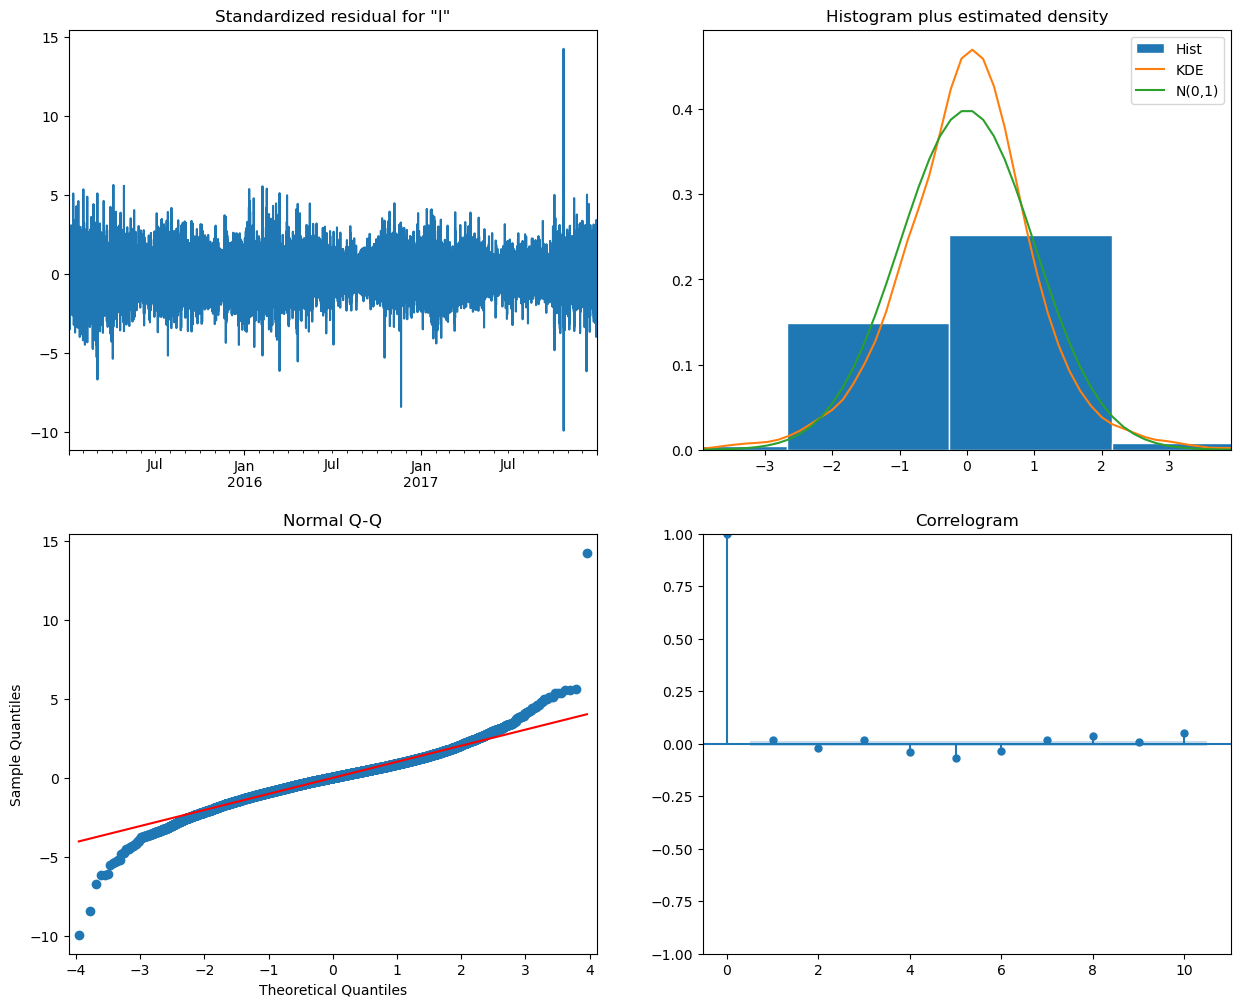

In [25]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

<Figure size 1000x500 with 0 Axes>

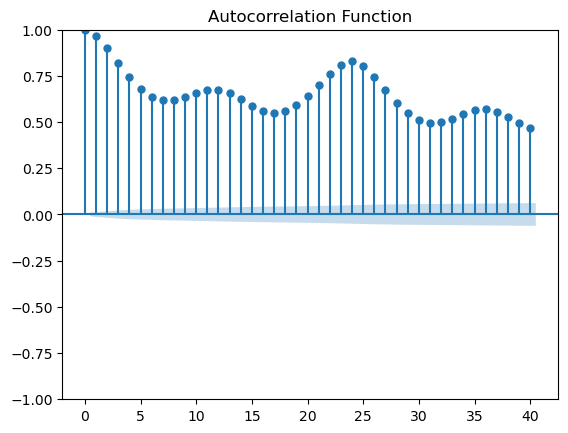

<Figure size 1000x500 with 0 Axes>

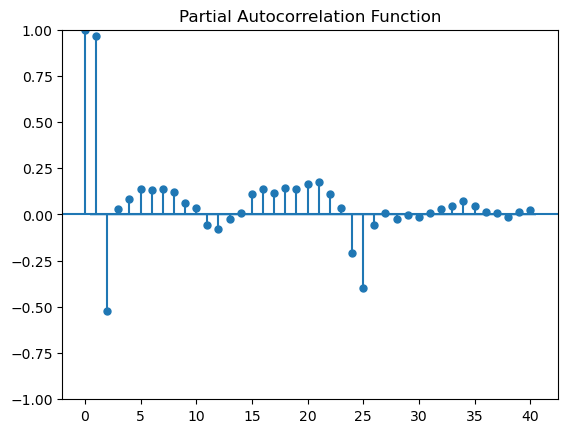

In [27]:
ts = df['price actual']

# Plot ACF
plt.figure(figsize=(10, 5))
plot_acf(ts, lags=40, alpha=0.05)
plt.title('Autocorrelation Function')
plt.show()

# Plot PACF
plt.figure(figsize=(10, 5))
plot_pacf(ts, lags=40, alpha=0.05)
plt.title('Partial Autocorrelation Function')
plt.show()

In [30]:
adf = adfuller(ts)  # Drop NA values if necessary
print('ADF Statistic:', adf[0])
print('p-value:', adf[1])
print('Critical Values:', adf[4])

if adf[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

ADF Statistic: -9.147016232851191
p-value: 2.75049348493422e-15
Critical Values: {'1%': -3.4305367814665044, '5%': -2.8616225527935106, '10%': -2.566813940257257}
Series is stationary


In [37]:
%%time
rmse, results, forecast, mean_forecast = sarimax_model_selection(y_train, X_train, 
                                                                 y_test, X_test, 1, 0, 2, 1, 0, 2, 12)

CPU times: user 17min 4s, sys: 5min 41s, total: 22min 46s
Wall time: 7min 59s


In [38]:
rmse

6.836061632062897

In [45]:
# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [63]:
y_train

time
2014-12-31 23:00:00+00:00    59.32
2015-01-01 00:00:00+00:00    56.04
2015-01-01 01:00:00+00:00    53.63
2015-01-01 02:00:00+00:00    51.73
2015-01-01 03:00:00+00:00    51.43
                             ...  
2017-12-31 19:00:00+00:00    23.95
2017-12-31 20:00:00+00:00    20.76
2017-12-31 21:00:00+00:00    19.02
2017-12-31 22:00:00+00:00    17.90
2017-12-31 23:00:00+00:00    20.88
Name: label_shifted, Length: 26305, dtype: float64

In [74]:
def optimize_sarimax(parameters_list, seasonal_parameters_list, y_train, X_train, y_test, X_test):
    results = []
    best_rmse = float("inf")
    best_cfg = None
    
    for param in parameters_list:
        for seasonal_param in seasonal_parameters_list:
            try:
                model = sm.tsa.statespace.SARIMAX(y_train,
                                                  exog=X_train,
                                                  order=param,
                                                  seasonal_order=seasonal_param,
                                                  enforce_stationarity=False,
                                                  enforce_invertibility=False)
                results = model.fit(disp=False)
                forecast = results.get_forecast(steps=len(y_test), exog=X_test)
                mean_forecast = forecast.predicted_mean
                rmse = mean_squared_error(y_test, mean_forecast, squared=False)
                
                # Store results
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_cfg = (param, seasonal_param)
                results.append([param, seasonal_param, rmse])
            except:
                continue
    
    return best_cfg, best_rmse, results

In [76]:
# Define the parameter ranges
p = d = q = range(0, 3)  # Example ranges
P = D = Q = range(0, 3)
s = [12] 

In [ ]:
parameters = list(itertools.product(p, d, q))
seasonal_parameters = [(x[0], x[1], x[2], s[0]) for x in list(itertools.product(P, D, Q))]

best_cfg, best_rmse, results = optimize_sarimax(parameters, seasonal_parameters, y_train, X_train, y_test, X_test)

print("Best Parameters:", best_cfg)
print("Best RMSE:", best_rmse)